In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from stats import *

from rdkit import Chem
from rdkit.Chem import PandasTools

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

RDKit ERROR: [16:29:41] Explicit valence for atom # 36 N, 5, is greater than permitted
RDKit ERROR: [16:29:41] ERROR: Could not sanitize molecule ending on line 660489


Original data:  (9614, 7)
Kept data:  (9614, 7)


,GENERIC_NAME,DRUGBANK_ID,DRUG_GROUPS,InChIKey,ID,SMILES,Mol
0,Elenbecestat,DB15391,investigational,AACUJFVOHGRMTR-DPXNYUHVSA-N,,CC1OCC2(c3cc(NC(=O)c4cnc(C(F)F)cn4)ccc3F)N=C(N...,

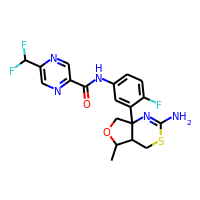

In [2]:
# Set file path
file = '../datasets/curated_data/drugbank.sdf.gz'
sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
moldf = PandasTools.LoadSDF(file, **sdfInfo)
print('Original data: ', moldf.shape)
# Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
# Remove missing RDKit molecules
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')
# Columns
print('Kept data: ', moldf.shape)
moldf.head(1)

,GENERIC_NAME,DRUGBANK_ID,DRUG_GROUPS,InChIKey,SMILES,Mol,sirms,sirms_ad,sirms_conf,dragon,dragon_ad,dragon_conf,morgan,morgan_ad,morgan_confidence
0,Elenbecestat,DB15391,investigational,AACUJFVOHGRMTR-DPXNYUHVSA-N,CC1OCC2(c3cc(NC(=O)c4cnc(C(F)F)cn4)ccc3F)N=C(N...,,0.0,NaN,0.64,0,0.0,0.81,0.0,NaN,0.57
1,Eticlopride,DB15492,experimental,AADCDMQTJNYOSS-LBPRGKRZSA-N,CCc1cc(Cl)c(OC)c(C(=O)NCC2CCCN2CC)c1O,,0.0,NaN,0.67,0,NaN,0.62,0.0,NaN,0.69
2,Pirnabine,DB12840,investigational,AADNQNOXNWEYHS-UHFFFAOYNA-N,CC(=O)Oc1cc(C)cc2c1C1=C(CCC(C)C1)C(C)(C)O2,,0.0,NaN,0.63,0,0.0,0.71,0.0,0.0,0.75
3,Dianhydrogalactitol,DB12873,investigational,AAFJXZWCNVJTMK-GUCUJZIJSA-N,OC(C1CO1)C(O)C1CO1,,0.0,NaN,0.67,1,NaN,0.50,0.0,0.0,0.80
4,"N-1,10-phenanthrolin-5-ylacetamide",DB08440,experimental,AAJXINSCZMZERD-UHFFFAOYSA-N,CC(=O)Nc1cc2cccnc2c2ncccc12,,0.0,0.0,0.70,0,NaN,0.66,0.0,0.0,0.71

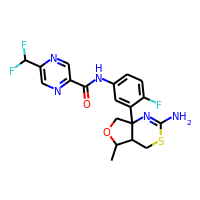
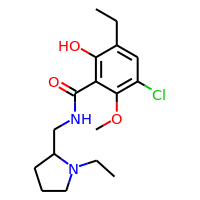
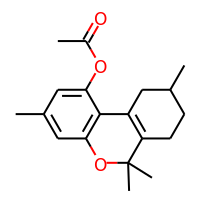
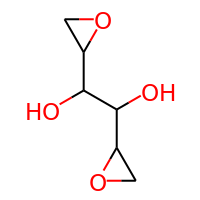
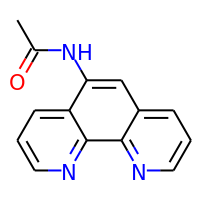

In [6]:
sirms_dragon = pd.read_excel('datasets/screened_compounds/drugbank_hits_qsar_sirms-morgan.xlsx')
sirms_dragon.drop(columns=['consensus', 'consensus_ad'], inplace=True)
morgan = pd.read_excel('datasets/screened_compounds/drugbank_hits_qsar_morgan.xlsx')
morgan.rename(columns={'Prediction': 'morgan', 'AD': 'morgan_ad', 'Confidence': 'morgan_confidence'}, inplace=True)

predictions = pd.merge(sirms_dragon, morgan[['InChIKey', 'morgan', 'morgan_ad', 'morgan_confidence']], how='inner', on='InChIKey')
for col in ['sirms', 'sirms_ad', 'dragon', 'dragon_ad', 'morgan', 'morgan_ad']:
    predictions[col].replace('Inactive',0,inplace=True)
    predictions[col].replace('Active',1,inplace=True)
predictions.head()

In [7]:
predictions = pd.merge(moldf[['InChIKey', 'SMILES']], predictions, how='inner', on='InChIKey')

,InChIKey,SMILES_x,GENERIC_NAME,DRUGBANK_ID,DRUG_GROUPS,SMILES_y,Mol,sirms,sirms_ad,sirms_conf,dragon,dragon_ad,dragon_conf,morgan,morgan_ad,morgan_confidence
0,AACUJFVOHGRMTR-DPXNYUHVSA-N,CC1OCC2(c3cc(NC(=O)c4cnc(C(F)F)cn4)ccc3F)N=C(N...,Elenbecestat,DB15391,investigational,CC1OCC2(c3cc(NC(=O)c4cnc(C(F)F)cn4)ccc3F)N=C(N...,,0.0,NaN,0.64,0,0.0,0.81,0.0,NaN,0.57
1,AADCDMQTJNYOSS-LBPRGKRZSA-N,CCc1cc(Cl)c(OC)c(C(=O)NCC2CCCN2CC)c1O,Eticlopride,DB15492,experimental,CCc1cc(Cl)c(OC)c(C(=O)NCC2CCCN2CC)c1O,,0.0,NaN,0.67,0,NaN,0.62,0.0,NaN,0.69
2,AADNQNOXNWEYHS-UHFFFAOYNA-N,CC(=O)Oc1cc(C)cc2c1C1=C(CCC(C)C1)C(C)(C)O2,Pirnabine,DB12840,investigational,CC(=O)Oc1cc(C)cc2c1C1=C(CCC(C)C1)C(C)(C)O2,,0.0,NaN,0.63,0,0.0,0.71,0.0,0.0,0.75
3,AAFJXZWCNVJTMK-GUCUJZIJSA-N,OC(C1CO1)C(O)C1CO1,Dianhydrogalactitol,DB12873,investigational,OC(C1CO1)C(O)C1CO1,,0.0,NaN,0.67,1,NaN,0.50,0.0,0.0,0.80
4,AAJXINSCZMZERD-UHFFFAOYSA-N,CC(=O)Nc1cc2cccnc2c2ncccc12,"N-1,10-phenanthrolin-5-ylacetamide",DB08440,experimental,CC(=O)Nc1cc2cccnc2c2ncccc12,,0.0,0.0,0.70,0,NaN,0.66,0.0,0.0,0.71

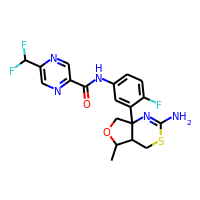
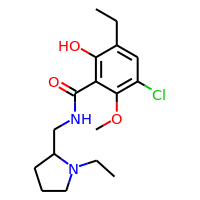
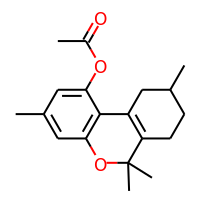
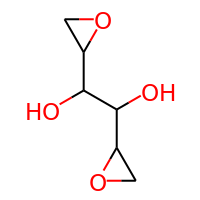
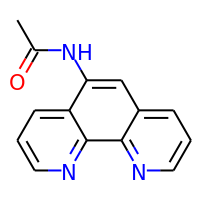

In [8]:
predictions.head()

In [9]:
# Consensus
predictions['consensus'] = (predictions.sirms + predictions.dragon + predictions.morgan)/3
predictions['consensus'] = np.where(predictions['consensus'] > 0.5, 1, np.where(predictions['consensus'] == 0.5, np.nan, 0))

In [10]:
# Consensus AD
for i in range(0, predictions.shape[0]):
    if all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = (predictions.sirms_ad[i] + predictions.dragon_ad[i] + predictions.morgan_ad[i])/3
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = (predictions.dragon_ad[i] + predictions.morgan_ad[i])/2
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = (predictions.sirms_ad[i] + predictions.morgan_ad[i])/2
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == True]):
        predictions.loc[i,'consensus_ad'] = (predictions.sirms_ad[i] + predictions.dragon_ad[i])/2
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == True]):
        predictions.loc[i,'consensus_ad'] = predictions.sirms_ad[i]
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == True]):
        predictions.loc[i,'consensus_ad'] = predictions.dragon_ad[i]
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = predictions.morgan_ad[i]
    else:
        predictions.loc[i,'consensus_ad']  = np.nan

predictions['consensus_ad'] = np.where(predictions['consensus_ad'] > 0.5, 1, np.where(predictions['consensus_ad'] == 0.5, np.nan, 0))

,InChIKey,SMILES_x,GENERIC_NAME,DRUGBANK_ID,DRUG_GROUPS,SMILES_y,Mol,sirms,sirms_ad,sirms_conf,dragon,dragon_ad,dragon_conf,morgan,morgan_ad,morgan_confidence,consensus,consensus_ad
0,AACUJFVOHGRMTR-DPXNYUHVSA-N,CC1OCC2(c3cc(NC(=O)c4cnc(C(F)F)cn4)ccc3F)N=C(N...,Elenbecestat,DB15391,investigational,CC1OCC2(c3cc(NC(=O)c4cnc(C(F)F)cn4)ccc3F)N=C(N...,,0.0,NaN,0.64,0,0.0,0.81,0.0,NaN,0.57,0.0,0.0
1,AADCDMQTJNYOSS-LBPRGKRZSA-N,CCc1cc(Cl)c(OC)c(C(=O)NCC2CCCN2CC)c1O,Eticlopride,DB15492,experimental,CCc1cc(Cl)c(OC)c(C(=O)NCC2CCCN2CC)c1O,,0.0,NaN,0.67,0,NaN,0.62,0.0,NaN,0.69,0.0,0.0
2,AADNQNOXNWEYHS-UHFFFAOYNA-N,CC(=O)Oc1cc(C)cc2c1C1=C(CCC(C)C1)C(C)(C)O2,Pirnabine,DB12840,investigational,CC(=O)Oc1cc(C)cc2c1C1=C(CCC(C)C1)C(C)(C)O2,,0.0,NaN,0.63,0,0.0,0.71,0.0,0.0,0.75,0.0,0.0
3,AAFJXZWCNVJTMK-GUCUJZIJSA-N,OC(C1CO1)C(O)C1CO1,Dianhydrogalactitol,DB12873,investigational,OC(C1CO1)C(O)C1CO1,,0.0,NaN,0.67,1,NaN,0.50,0.0,0.0,0.80,0.0,0.0
4,AAJXINSCZMZERD-UHFFFAOYSA-N,CC(=O)Nc1cc2cccnc2c2ncccc12,"N-1,10-phenanthrolin-5-ylacetamide",DB08440,experimental,CC(=O)Nc1cc2cccnc2c2ncccc12,,0.0,0.0,0.70,0,NaN,0.66,0.0,0.0,0.71,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9609,ZZTMFGIGOADCFX-UHFFFAOYSA-N,CCNC(=O)c1cn2ncnc(Nc3cc(C(=O)NOC)ccc3C)c2c1C,N-ethyl-4-{[5-(methoxycarbamoyl)-2-methylpheny...,DB06940,experimental,CCNC(=O)c1cn2ncnc(Nc3cc(C(=O)NOC)ccc3C)c2c1C,,0.0,0.0,0.76,1,NaN,0.58,0.0,0.0,0.79,0.0,0.0
9610,ZZUBHVMHNVYXRR-UHFFFAOYSA-N,Oc1ccc(C2=Cc3ccc(O)cc3OC2)cc1,Idronoxil,DB04915,investigational,Oc1ccc(C2=Cc3ccc(O)cc3OC2)cc1,,0.0,NaN,0.64,0,0.0,0.76,0.0,NaN,0.65,0.0,0.0
9611,ZZUFCTLCJUWOSV-UHFFFAOYSA-N,NS(=O)(=O)c1cc(C(=O)O)c(NCc2ccco2)cc1Cl,Furosemide,DB00695,approved; vet_approved,NS(=O)(=O)c1cc(C(=O)O)c(NCc2ccco2)cc1Cl,,0.0,0.0,0.72,0,NaN,0.69,0.0,NaN,0.67,0.0,0.0
9612,ZZVGLDBDDYESAB-UHFFFAOYSA-N,N=C(Nc1ccc(CCNCc2cccc(Cl)c2)cc1)c1cccs1,N-(4-{2-[(3-chlorobenzyl)amino]ethyl}phenyl)th...,DB03449,experimental,N=C(Nc1ccc(CCNCc2cccc(Cl)c2)cc1)c1cccs1,,0.0,0.0,0.75,0,NaN,0.62,0.0,0.0,0.82,0.0,0.0

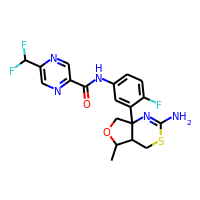
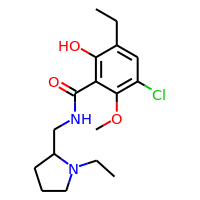
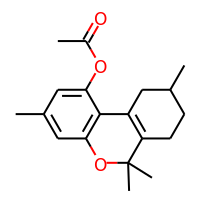
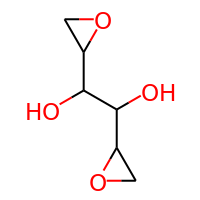
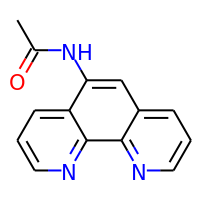
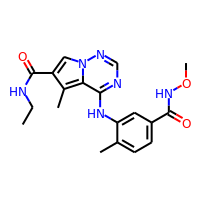
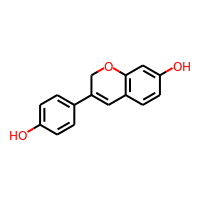
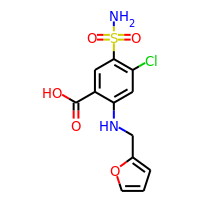
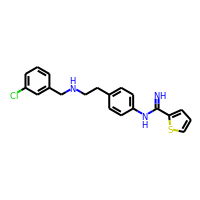
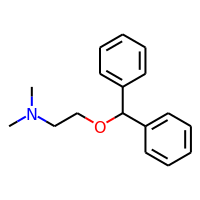

In [11]:
predictions

In [13]:
predictions.drop('Mol', axis=1)
with pd.ExcelWriter('datasets/screened_compounds/drugbank_hits_qsar_consensus.xlsx') as writer:
    predictions.to_excel(writer, sheet_name='consensus', index=False)